In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

# Chapter 4: Traning Models

- *Why understand the math behind machine learnings models?* (Q)
    - Quickly hone in on appropriate algorithms, or discard inappropriate ones
    - Easily narrow down the search space of hyperparameters
    - UNderstand debugging and model analysis

# Linear Regression

- Linear Regression is a conceptually simple model that predicts by computing a weighted sum of the input features, plus offset
    - $\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_n x_n $
    - Or, more compactly, $\hat{y} = h_\theta(\mathbf{x}) = \pmb{\theta} \cdot \pmb{x} = \pmb{\theta}^\intercal \pmb{x} $
        - 1st feature in the $\pmb{x}$ vector is always 1, to create the offset
        - $h_\theta(\pmb{x})$ is the hypothesis function, which describes the target as a function of the features
        - The value of $ \pmb{\theta} $ that minimizes the RMSE gives the model with best fit
        - In practice, it is easier to minimize the MSE instead of the RMSE.  This gives the same reuslt

- Mean Squared Error (MSE) is a measure of the average "miss" of the predictions from the ground truth:
$$ MSE(\pmb{X}, h_\theta) = \frac{1}{m} \sum_{i=1}^{m} (\pmb{\theta}^\intercal \pmb{x}_i - y_i )^{2} $$

- Root Mean Squared Error (RMSE) is simply the square root of the MSE:
$$ RMSE(\pmb{X}, h_\theta) = \sqrt{MSE(\pmb{X}, h_\theta)} $$

- *In what situation would you train a machine learning model with a different loss function than the function used to evaluate model performance?* (Q)
    - A different function might be easier/quicker to compute, such as using MSE instead of RMSE to fit a Linear Regression model
    - A different function might be easier to differentiate
    - In order to contrain the model, such as in a regularization setting

- The *Normal Equation* gives the closed-form solution to the optimization problem:
$$ \hat{\pmb{\theta}} = (\pmb{X}^\intercal \pmb{X})^{-1} \pmb{X}^\intercal \pmb{y} $$

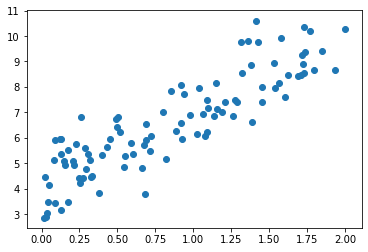

In [2]:
# An example
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)  # Normally distributed noise

plt.scatter(X, y);

In [3]:
# Compute the solution using the normal equation.
# This implementation calls out the fact that the solution
# is achieved with a chain of matrix multiplications

X_withbias = np.c_[np.ones(X.shape), X]
theta_hat = np.linalg.inv(X_withbias.T.dot(X_withbias)).dot(X_withbias.T).dot(y)  # Normal equation

In [4]:
# theta_hat is close to, but doens't precisely equal, the
# values hardcoded in the cell above.
theta_hat

array([[4.1241079],
       [2.8811973]])

In [5]:
X_new = np.array([[0], [2]])
X_new_withbias = np.c_[np.ones(X_new.shape), X_new]
y_pred = X_new_withbias.dot(theta_hat)

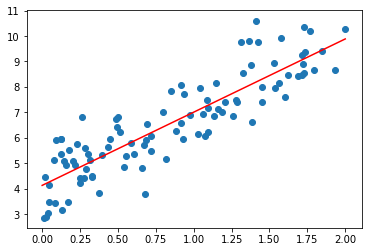

In [6]:
plt.scatter(X, y)
plt.plot(X_new, y_pred, color="red");

In [7]:
# Another example, this time using sklearn
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [8]:
# Again, the learned parameters approximate, but don't equal,
# the hardcoded values.
lin_reg.coef_, lin_reg.intercept_

(array([[2.8811973]]), array([4.1241079]))

In [9]:
# Finally, another example using numpy, which the sklearn
# implementation is based on.
theta_hat_svd, resid, rank, s = np.linalg.lstsq(X_withbias, y, rcond=1e-6)
theta_hat_svd

array([[4.1241079],
       [2.8811973]])

- The last example computes the Moore-Penrose (pseudo-)inverse of $\pmb{X}$:
    - $ \hat{\pmb{\theta}} = \pmb{X}^{+}\pmb{y} $
    - Can be computed directly with `np.linalg.pinv(X_withbias).dot(y)`
    - Moorse-Penrose inverse is calculated using SVD
        - $ \pmb{U} \pmb{\Sigma} \pmb{V}^\intercal $
        - `np.linalg.svd()`
        - Computed by taking SVD of $\pmb{X}$, set all small values in $\pmb{\Sigma}$ to zero, invert all its nonzero values, then transpose to get $ \pmb{U} \pmb{\Sigma}^{+} \pmb{V}^\intercal $
    - This is more efficient than copmuting the normal equation
    - More robust to cases where $ \pmb{X}^\intercal \pmb{X} $ cannot be inverted (i.e. it's singular)
        - Such as $n_{cols} > n_{rows}$ or in multicollinearity setting

- Computational complexity of the Moore-Penrose approach is better than the Normal Equation approach
    - Moore-Penrose approach used by `sklearn` is about $O(n^2)$
    - Inversion of an $(n+1) \times (n+1)$ matrix as in the normal equation is about $O(n^{2.4})$ to $O(n^3)$
    - Efficiency of both approaches deteriorates in high dimensions
    - Linear in the number of rows, so both approaches work well with large datasets
    - Predictions are fast once model has been trained: linear w.r.t. both number of features and rows

## Gradient Descent

- In addition to the analytic method described above, a gradient descent-based method can be used
- Gradient descent is a generic algorithm that can be used to find an optimum solution to many problems
- The idea is to iteratively update model parameters in such a way that the loss is progressively minimized
- Step size, i.e. learning rate, is an important parameter in the algorithm
    - Too-large step size can cause the algorithm to diverge
    - Too-small step size lengthens the time needed to converge
    - In practice, learning rate is progressively decreased to better "hone in" on an optimum
- Number of iterations must also be set well
    - Too low and the algorithm won't yet have arrived at the optimum
    - Too high is inefficient once the parameters stop changing
- In practice, it is useful to "early stop" the algorithm once the gradient gets very small, i.e. has a norm below $ \epsilon $, the tolerance
    - When the loss is convex, the alrogithm takes $ O(\frac{1}{\epsilon}) $ time to reach the optimum.  Dividing $\epsilon$ by 10 increases can increase the time by a factor of 10.

- Gradient descent can't be guaranteed to find the global minimum in a complex loss landscape
- However, if the loss function is convex, Gradient Descent will converge (given a not-too-large learning rate)

- Gradient descent benefits from features being scaled, otherwise it can take longer to converge

- To implement the Gradient Descent algorithmL
    - Compute the gradient of the cost function w.r.t. each parameter $\theta_j$
        - In the linear regrerssion example, this is $$ \frac{\partial}{\partial \theta_j}MSE(\pmb{\theta}) = \frac{2}{m}\sum_{i=1}^{m} (\pmb{\theta}^\intercal \pmb{x}_i - y_i)x_{ij} $$
        - This can be computed in one go: $$ \nabla_{\theta}MSE(\pmb{\theta}) = \frac{2}{m}\pmb{X}^\intercal(\pmb{X}\pmb{\theta} - \pmb{y}) $$
    - The gradient is a vector of partial derivatives, with length equal to the number of model parameters
    - Note that this requires computing the gradient over the _entire_ training set at each step in teh descent.  This is not very efficient, so there are modifications to the algorithm that give a speedup
    - Finally, compute the next step in terms of the previous step: $$ \pmb{\theta}_{next} = \pmb{\theta} = \eta\nabla_{\theta}MSE(\pmb{\theta}) $$

In [10]:
eta = 0.1
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
    gradients = 2/m * X_withbias.T.dot(X_withbias.dot(theta) - y)
    theta = theta - eta * gradients
    
theta

array([[4.1241079],
       [2.8811973]])

- Stochastic Gradient Descent balances the advantages and disadvantages of calculating the gradient on the entire training data set
    - Computationally expensive to use entire training set, but contains the most information possible
    - SGD performs the process on a single training instance per iteration, instead of the entire training set
    - Result is a faster algorithm, the speed of which comes at the cost of less reliable gradient information
    - As a result, model loss is more likely to "bounce around" before settling at the optimum
    - Also, the alrgorithm will stop close to, but not on the optimum point
    - In practice, slowly decreasing the learning rate helps prevent the algorithm from jumping off the optimum by too much
    - Too-fast reduction may result in the algorithm being stuck in a local minimum
    - Too-slow reduction may reuslt in ending up fairly far from the actual optimum point

In [11]:
# numpy implementation

n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_withbias[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m * i)
        theta = theta - eta * gradients

In [12]:
theta

array([[4.02585268],
       [2.22979333]])

In [13]:
# sklearn's SGDRegression defaults to using MSE cost function

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [14]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.09199534]), array([2.85452299]))

- Minibatch Gradient Descent is a compromise between the efficieny of SGD and the quality of computing the gradient on the entire training set
- Minibatch Gradient Descent selects a random "mini-batch" of training data at each iteration to compute the gradient

## Polynomial Regression

- Polynomial regression models the data as a curve, rather than a stright line
- Adds higher-order features
    - Enables the response to vary with a feature $x$, based on the current level of $x$

In [17]:
# Some simulated data
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

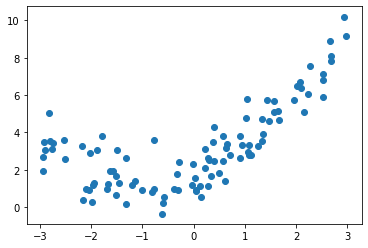

In [20]:
plt.scatter(X, y);

In [27]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [28]:
lin_reg  = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.8284436]), array([[1.00807613, 0.51914595]]))

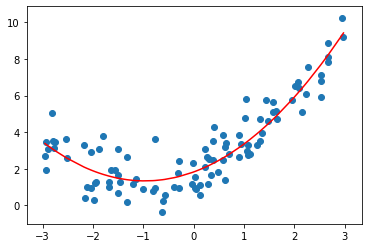

In [50]:
y_hat = lin_reg.predict(X_poly)
ixs = X.T.argsort()[0]
plt.plot(X[ixs], y_hat[ixs], color='red')
plt.scatter(X, y);

- Polynomial Regression can also be used to create interaction terms between the features
- This is powerful but can result in combinatorial explosion
    - A degree of `d` used on a dataset with `n` features will results in $\frac{(n+d)!}{d!n!}$ features!

Left off at Learning Curves, pg 191